"""
An example to demonstrate online control of lorenz system

Authors: 
Hao Zhang

References:
Zhang, Hao, Clarence W. Rowley, Eric A. Deem, and Louis N. Cattafesta.
"Online dynamic mode decomposition for time-varying systems."
SIAM Journal on Applied Dynamical Systems 18, no. 3 (2019): 1586-1609.

Created:
June 2017.
"""

In [1]:
!pip install -r requirements.txt

  Using cached slycot-0.4.0.0.tar.gz (1.5 MB)
  Installing build dependencies ... |^C
anceled
ERROR: Operation cancelled by user


In [2]:
!pip list

Package             Version    Location
------------------- ---------- ---------------------------------------
appdirs             1.4.4
appnope             0.1.2
argon2-cffi         20.1.0
async-generator     1.10
attrs               20.3.0
backcall            0.2.0
black               20.8b1
bleach              3.3.0
certifi             2020.12.5
cffi                1.14.5
chardet             4.0.0
click               7.1.2
colorama            0.4.4
control             0.8.4
cycler              0.10.0
decorator           4.4.2
defusedxml          0.6.0
docutils            0.16
entrypoints         0.3
idna                2.10
iniconfig           1.1.1
ipykernel           5.4.3
ipython             7.20.0
ipython-genutils    0.2.0
ipywidgets          7.6.3
jedi                0.18.0
Jinja2              2.11.3
jsonschema          3.2.0
jupyter             1.0.0
jupyter-client      6.1.11
jupyter-console     6.2.0
jupyter-core        4.7.1
jupyterlab-pygments 0.1.2
jupyterlab-widgets  1.0

Uncontrolled system simulation
-  classical butterfly trajectory

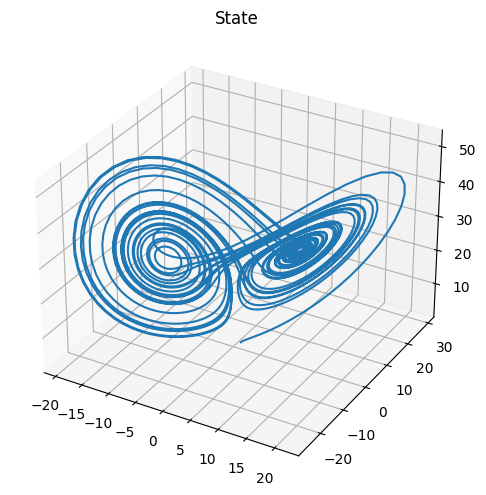

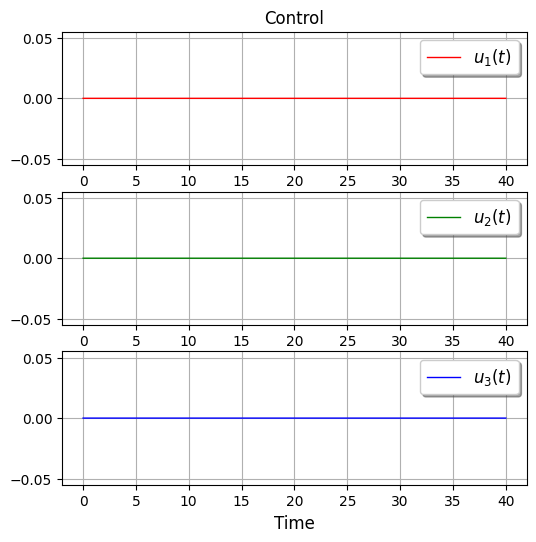

In [4]:
"""
An example to demonstrate online control of lorenz system

Authors: 
Hao Zhang

References:
Zhang, Hao, Clarence W. Rowley, Eric A. Deem, and Louis N. Cattafesta.
"Online dynamic mode decomposition for time-varying systems."
SIAM Journal on Applied Dynamical Systems 18, no. 3 (2019): 1586-1609.

Created:
June 2017.
"""

import random
import matplotlib.pyplot as plt
import numpy as np
from osysid import OnlineLinearModel
from control import lqr, StateSpace, ctrb

random.seed(20210220)
np.random.seed(20210220)

# define dynamics
# https://en.wikipedia.org/wiki/Lorenz_system
# Lorenz
n = 3 # state dimension
k = 3 # input dimension
# output = state (full state observation)
sigma = 10
beta = 8.0 / 3.0
rho = 28
def dyn(x, u):
    assert x.shape == (n,)
    assert u.shape == (k,)
    f = np.zeros(n) # dx/dt = f(x, u)
    f[0] = sigma * (x[1] - x[0]) + u[0]
    f[1] = x[0] * (rho - x[2]) - x[1] + u[1]
    f[2] = x[0] * x[1] - beta * x[2] + u[2]
    return f

# fixed point (unstable)
phi = np.sqrt(beta * (rho - 1))
xf1 = np.array([phi, phi, rho - 1])
xf2 = np.array([-phi, -phi, rho - 1])
xf3 = np.array([0, 0, 0])

# set up simulation parameter
dt = 0.01
tmax, tc = 40, 0.4
T, kc = int(tmax / dt), int(tc / dt)
tspan = np.linspace(0, tmax, T + 1)

# online linear system identification setup
alpha = 0.01 ** (1.0 / kc) # 99% decay after kc samples
olm = OnlineLinearModel(n, k, None, alpha)

# store data mtrices
x = np.zeros([n, T])
u = np.zeros([k, T])

# initial condition, state and control
x0 = np.array([1, 1, 1])
u0 = np.array([0, 0, 0])

# initial condition
x[:, 0] = x0
u[:, 0] = u0

# uncontrolled system simulation
for t in range(1, T):
    # forward the system for one step
    x[:, t] = x[:, t - 1] + dt * dyn(x[:, t - 1], u[:, t - 1])
    u[:, t] = 0


def plot_state(x):
    plt.rcParams['figure.dpi'] = 100
    fig = plt.figure(figsize=(6, 6))
    ax = fig.gca(projection="3d")
    ax.plot(x[0, :], x[1, :], x[2, :])
    plt.title("State")
    plt.draw()
    plt.grid()
    plt.show()


def plot_control(u):
    plt.rcParams['figure.dpi'] = 100
    fig, axs = plt.subplots(3, figsize=(6, 6))

    axs[0].plot(tspan[1:], u[0, :], "r-", linewidth=1.0, label="$u_1(t)$")
    axs[0].legend(loc="best", fontsize=12, shadow=True)
    axs[0].grid()
    axs[0].set_title("Control")

    axs[1].plot(tspan[1:], u[1, :], "g-", linewidth=1.0, label="$u_2(t)$")
    axs[1].legend(loc="best", fontsize=12, shadow=True)
    axs[1].grid()

    axs[2].plot(tspan[1:], u[2, :], "b-", linewidth=1.0, label="$u_3(t)$")
    axs[2].legend(loc="best", fontsize=12, shadow=True)
    axs[2].grid()

    axs[2].set_xlabel("Time", fontsize=12)


# plot state and control
plot_state(x)
plot_control(u)

Controlled system simulation
- Purely data-driven
- Real-time model learning
- Adaptive to new data
- Closed loop control
- Stabilizes system at unstable fixed point

In [ ]:
# controlled system simulation
# we want to stabilize system at fixed point xf1
# need to shift state by -xf1

# initial condition, state and control
x[:, 0] = x0
u[:, 0] = u0

# control system simulation
for t in range(1, T):
    # forward the system for one step
    x[:, t] = x[:, t - 1] + dt * dyn(x[:, t - 1], u[:, t - 1])
    # use new measurement to update online system identification
    # try stabilize at xf1, shift state by -xf1
    olm.update(x[:, t - 1] - xf1, u[:, t - 1], x[:, t] - xf1)
    # apply control if we have collected enough data
    if t > 4 * max(n, n + k):
        # convert to continuous representation
        Ac = (olm.A - np.eye(n)) / dt
        Bc = olm.B / dt
        # get LQR gain, output = state
        sys = StateSpace(Ac, Bc, np.eye(n), np.zeros((n, k)), dt=0)
        K, S, E = lqr(sys, 2 * np.eye(n), np.eye(k))
        # apply control
        u[:, t] = -1.0 * K.dot(x[:, t] - xf1)
        # clip control
        u[:, t] = np.clip(u[:, t], -10, 10)
        # smooth control
        w = 0.5
        u[:, t] = (1 - w) * u[:, t - 1] + w * u[:, t]
        # show progress
        if t % 1000 == 0:
            print(f"t={t * dt}")
            print(f"x(t)={x[:, t]}")
            print(f"xf1={xf1}")
            print(f"u(t)={u[:, t]}")
            print(f"Ac={Ac}")
            print(f"Bc={Bc}")
            print(f"K={K}\n")
    # random small perturbation if not enough data yet
    else:
        u[:, t] = 1e-1 * np.random.randn(k)

plot_state(x)
plot_control(u)
assert np.linalg.norm(x[:, -1] - xf1) < 1e-1